### Neural network from scratch

To implement a neural network from scratch, we will do the following:
1. Define the lowest unit, class Value
2. Define and implement graph creation
3. Implement differentiation for simple operations
4. What about operations with scalars? Value object + 2.0? Handle that
5. Implement backward prop
6. Test backward propagation
7. Build more complex operations
8. Build Neuron
9. Build Layer
10. Build Neural Networks

In [1]:
from typing import Tuple, Optional
from __future__ import annotations
from graphviz import Digraph

### First pass at building the lowest unit

In [2]:
class Value:
    '''Lowest unit of this activity. Represents a value, on which we will do operations, differentiation etc.
       I need to keep track of: Value, operation that created it, parents that led to its creation, differentiation function?
    '''
    def __init__(self, data: float, name: Optional[str] = None, _op: str = None, _parents: Tuple['Value'] = ()) -> None:
        self.data = data
        self._backward = lambda : None
        self._op = _op
        self._parents = _parents
        self.name = name
        self.grad = 0

    def __repr__(self) -> str:
        return f'Value(data={self.data}, name={self.name}, op={self._op})'

    def __add__(self, other: Value) -> Value:
        out = Value(self.data + other.data, _op='+', _parents=(self, other))
        # def _backward():
        #     out.grad = X
        #     return None
        # out._backward = _backward
        return out
        
    def __mul__(self, other: Value) -> Value:
        out = Value(self.data * other.data, _op='*', _parents=(self, other))
        def _backward():
            return None
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return other * self
    
    def __exp__(self, other):
        raise NotImplementedError
    
    def tanh(self, other):
        raise NotImplementedError

In [3]:
a = Value(4.0, 'a')
b = Value(5.0, 'b')

c = a + b; c.name='c'
d = Value(5.0, 'd')
e = c * d; e.name='e'

In [4]:
def traverse(current: Value, nodes=None, edges=None):
    '''traverse to build nodes and edges for computational graph'''
    if nodes is None:
        nodes = []
    if edges is None:
        edges = []
    if current not in nodes:
        nodes.append(current)
        for parent in current._parents:
            edges.append((parent, current))
            traverse(parent, nodes, edges)
    return nodes, edges


def build_graph(current: Value):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges= traverse(current)
    print(nodes)
    print(edges)

    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label=f'{n.name} | data: {n.data} | grad: {n.grad}', shape='record')

        if n._op:
            dot.node(name=uid+n._op, label=n._op)
            dot.edge(uid+n._op, uid)

    for node1, node2 in edges:
        dot.edge(str(id(node1)), str(id(node2))+node2._op)

    return dot

[Value(data=45.0, name=e, op=*), Value(data=9.0, name=c, op=+), Value(data=4.0, name=a, op=None), Value(data=5.0, name=b, op=None), Value(data=5.0, name=d, op=None)]
[(Value(data=9.0, name=c, op=+), Value(data=45.0, name=e, op=*)), (Value(data=4.0, name=a, op=None), Value(data=9.0, name=c, op=+)), (Value(data=5.0, name=b, op=None), Value(data=9.0, name=c, op=+)), (Value(data=5.0, name=d, op=None), Value(data=45.0, name=e, op=*))]


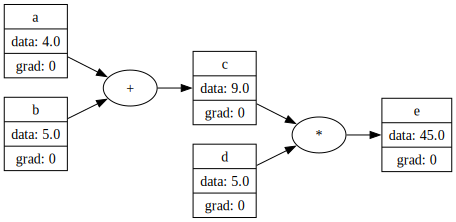

In [5]:
build_graph(e)

### Understanding how we can build gradients

In [6]:
def understanding_grads():
    a = Value(4.0, 'a')
    b = Value(5.0, 'b')
    c = a + b; c.name='c'
    d = Value(5.0, 'd')
    e = c * d; e.name='e'
    e1 = e.data

    h = 0.001
    a = Value(4.0, 'a')
    b = Value(5.0, 'b')
    c = a + b; c.name='c'
    d = Value(5.0, 'd')
    e = c * d; e.name='e'
    e2 = e.data + h

    print((e2-e1)/h)

understanding_grads()

0.9999999999976694


**This means that the gradient of the last node should start with 1.** Because if we change the node with respect to itself, it will always change linearly i.e 
For every unit we change of E, E will change by 1 unit. So dE/dE = 1

In [7]:
def multiplication_gradient():
    a = Value(4.0, 'a')
    b = Value(5.0, 'b')
    c = a + b; c.name='c'
    d = Value(5.0, 'd')
    e = c * d; e.name='e'
    e1 = e.data

    h = 0.001
    a = Value(4.0, 'a')
    b = Value(5.0, 'b')
    c = a + b; c.name='c'
    d = Value(5.0, 'd')
    d.data += h
    e = c * d; e.name='e'
    e2 = e.data

    print((e2-e1)/h)

multiplication_gradient()

9.000000000000341


**Gradient of a multiplication where e = c * d i.e. de/dc = d and de/dd = c as shown above**

In [8]:
e.grad = 1.0
c.grad = d.data
d.grad = c.data

[Value(data=45.0, name=e, op=*), Value(data=9.0, name=c, op=+), Value(data=4.0, name=a, op=None), Value(data=5.0, name=b, op=None), Value(data=5.0, name=d, op=None)]
[(Value(data=9.0, name=c, op=+), Value(data=45.0, name=e, op=*)), (Value(data=4.0, name=a, op=None), Value(data=9.0, name=c, op=+)), (Value(data=5.0, name=b, op=None), Value(data=9.0, name=c, op=+)), (Value(data=5.0, name=d, op=None), Value(data=45.0, name=e, op=*))]


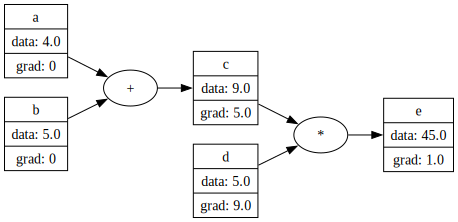

In [9]:
build_graph(e)

In [10]:
def addition_gradient():
    a = Value(4.0, 'a')
    b = Value(5.0, 'b')
    c = a + b; c.name='c'
    d = Value(5.0, 'd')
    e = c * d; e.name='e'
    e1 = e.data

    h = 0.001
    a = Value(4.0, 'a')
    a.data += h
    b = Value(5.0, 'b')
    c = a + b; c.name='c'
    d = Value(5.0, 'd')
    e = c * d; e.name='e'
    e2 = e.data

    print((e2-e1)/h)

addition_gradient()

5.000000000009663


**Chain Rule**: 
Gradient we want = Local Gradient * Global Gradient/ Gradient so far
de/da = dc/da * de/dc

So in this case gradient of de / da = 5; and similarly gradient of de / db = 5
Also interesting to note that gradient of a positive operation just ends up taking the gradient so far and propagating it between the participating nodes.

In [11]:
a.grad = c.grad
b.grad = c.grad

[Value(data=45.0, name=e, op=*), Value(data=9.0, name=c, op=+), Value(data=4.0, name=a, op=None), Value(data=5.0, name=b, op=None), Value(data=5.0, name=d, op=None)]
[(Value(data=9.0, name=c, op=+), Value(data=45.0, name=e, op=*)), (Value(data=4.0, name=a, op=None), Value(data=9.0, name=c, op=+)), (Value(data=5.0, name=b, op=None), Value(data=9.0, name=c, op=+)), (Value(data=5.0, name=d, op=None), Value(data=45.0, name=e, op=*))]


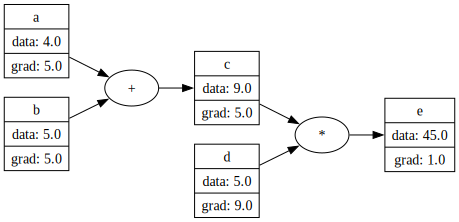

In [12]:
build_graph(e)

### Adding Backward Prop functions

In [13]:
class Value:
    '''Lowest unit of this activity. Represents a value, on which we will do operations, differentiation etc.
       I need to keep track of: Value, operation that created it, parents that led to its creation, differentiation function?
    '''
    def __init__(self, data: float, name: Optional[str] = None, _op: str = None, _parents: Tuple['Value'] = ()) -> None:
        self.data = data
        self._backward = lambda : None
        self._op = _op
        self._parents = _parents
        self.name = name
        self.grad = 0

    def __repr__(self) -> str:
        return f'Value(data={self.data}, name={self.name}, op={self._op})'

    def __add__(self, other: Value) -> Value:
        out = Value(self.data + other.data, _op='+', _parents=(self, other))
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward
        return out
        
    def __mul__(self, other: Value) -> Value:
        out = Value(self.data * other.data, _op='*', _parents=(self, other))
        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return other * self
    
    def __exp__(self, other):
        raise NotImplementedError
    
    def tanh(self, other):
        raise NotImplementedError

In [14]:
a = Value(4.0, 'a')
b = Value(5.0, 'b')
c = a + b; c.name='c'
d = Value(5.0, 'd')
e = c * d; e.name='e'
e.grad = 1.0

[Value(data=45.0, name=e, op=*), Value(data=9.0, name=c, op=+), Value(data=4.0, name=a, op=None), Value(data=5.0, name=b, op=None), Value(data=5.0, name=d, op=None)]
[(Value(data=9.0, name=c, op=+), Value(data=45.0, name=e, op=*)), (Value(data=4.0, name=a, op=None), Value(data=9.0, name=c, op=+)), (Value(data=5.0, name=b, op=None), Value(data=9.0, name=c, op=+)), (Value(data=5.0, name=d, op=None), Value(data=45.0, name=e, op=*))]


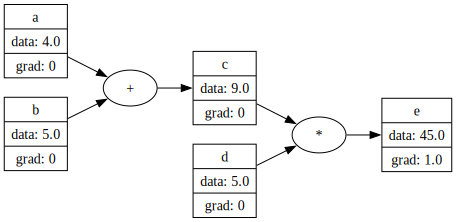

In [15]:
build_graph(e)

In [16]:
e._backward()

[Value(data=45.0, name=e, op=*), Value(data=9.0, name=c, op=+), Value(data=4.0, name=a, op=None), Value(data=5.0, name=b, op=None), Value(data=5.0, name=d, op=None)]
[(Value(data=9.0, name=c, op=+), Value(data=45.0, name=e, op=*)), (Value(data=4.0, name=a, op=None), Value(data=9.0, name=c, op=+)), (Value(data=5.0, name=b, op=None), Value(data=9.0, name=c, op=+)), (Value(data=5.0, name=d, op=None), Value(data=45.0, name=e, op=*))]


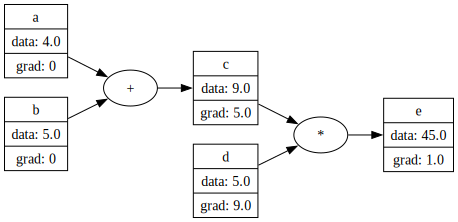

In [17]:
build_graph(e)

We must implement topological sort in order to automatically backpropagating gradients from the last node. 

Topological sort is appropriate here, because it lets us create an ordering for a DAG, such that a node is not visited until all it's dependencies are resolved. 

In [19]:
ordering = []
visited = []
def topological_traversal(e):
    if e not in visited:
        visited.append(e)
        if e._parents:
            for parent in e._parents:
                topological_traversal(parent)
        ordering.append(e)

In [20]:
topological_traversal(e)

**Updating our class Value now**

In [23]:
class Value:
    '''Lowest unit of this activity. Represents a value, on which we will do operations, differentiation etc.
       I need to keep track of: Value, operation that created it, parents that led to its creation, differentiation function?
    '''
    def __init__(self, data: float, name: Optional[str] = None, _op: str = None, _parents: Tuple['Value'] = ()) -> None:
        self.data = data
        self._backward = lambda : None
        self._op = _op
        self._parents = _parents
        self.name = name
        self.grad = 0

    def __repr__(self) -> str:
        return f'Value(data={self.data}, name={self.name}, op={self._op})'

    def __add__(self, other: Value) -> Value:
        out = Value(self.data + other.data, _op='+', _parents=(self, other))
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward
        return out
        
    def __mul__(self, other: Value) -> Value:
        out = Value(self.data * other.data, _op='*', _parents=(self, other))
        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return other * self
    
    def __exp__(self, other):
        raise NotImplementedError
    
    def tanh(self, other):
        raise NotImplementedError
    
    def backward(self):
        ordering = []
        visited = []
        def topological_traversal(e):
            if e not in visited:
                visited.append(e)
                if e._parents:
                    for parent in e._parents:
                        topological_traversal(parent)
                ordering.append(e)
        topological_traversal(self)

        for node in reversed(ordering):
            node._backward()

In [24]:
a = Value(4.0, 'a')
b = Value(5.0, 'b')
c = a + b; c.name='c'
d = Value(5.0, 'd')
e = c * d; e.name='e'
e.grad = 1.0

[Value(data=45.0, name=e, op=*), Value(data=9.0, name=c, op=+), Value(data=4.0, name=a, op=None), Value(data=5.0, name=b, op=None), Value(data=5.0, name=d, op=None)]
[(Value(data=9.0, name=c, op=+), Value(data=45.0, name=e, op=*)), (Value(data=4.0, name=a, op=None), Value(data=9.0, name=c, op=+)), (Value(data=5.0, name=b, op=None), Value(data=9.0, name=c, op=+)), (Value(data=5.0, name=d, op=None), Value(data=45.0, name=e, op=*))]


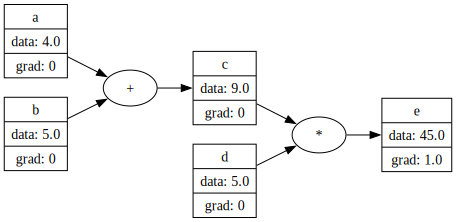

In [25]:
build_graph(e)

In [26]:
e.backward()

[Value(data=45.0, name=e, op=*), Value(data=9.0, name=c, op=+), Value(data=4.0, name=a, op=None), Value(data=5.0, name=b, op=None), Value(data=5.0, name=d, op=None)]
[(Value(data=9.0, name=c, op=+), Value(data=45.0, name=e, op=*)), (Value(data=4.0, name=a, op=None), Value(data=9.0, name=c, op=+)), (Value(data=5.0, name=b, op=None), Value(data=9.0, name=c, op=+)), (Value(data=5.0, name=d, op=None), Value(data=45.0, name=e, op=*))]


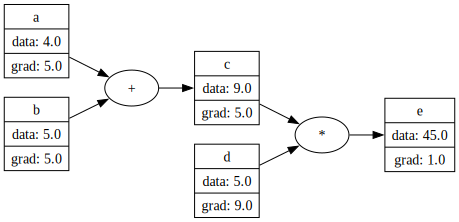

In [27]:
build_graph(e)

#### Forgot one thing!
 
The gradient for the last node must be 1 instead of 0!

### Testing backprop with more complex operations

### Building in more complex operations into our Value class

### Build Neuron

### Build Layer

### Build simple MLP

### Stochastic Gradient Descent

### Implementing end to end